# Sprint 8
## Tasca M8 T01

## Exercici 1

Descarrega el dataset adjunt, de registres de publicacions a Facebook sobre Tailàndia, i classifica els diferents registres utilitzant l'algorisme de K-means.

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='darkgrid', palette='deep')

df=pd.read_csv('Publicacions Facebook Thailandia.csv')
dfc=df.dropna(axis=1)
dfc['status_published']=pd.to_datetime(dfc['status_published']).dt.month
dfc.info()
df.info()
dfc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   status_id         7050 non-null   object
 1   status_type       7050 non-null   object
 2   status_published  7050 non-null   int64 
 3   num_reactions     7050 non-null   int64 
 4   num_comments      7050 non-null   int64 
 5   num_shares        7050 non-null   int64 
 6   num_likes         7050 non-null   int64 
 7   num_loves         7050 non-null   int64 
 8   num_wows          7050 non-null   int64 
 9   num_hahas         7050 non-null   int64 
 10  num_sads          7050 non-null   int64 
 11  num_angrys        7050 non-null   int64 
dtypes: int64(10), object(2)
memory usage: 661.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  ---

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,246675545449582_1649696485147474,video,4,529,512,262,432,92,3,1,1,0
1,246675545449582_1649426988507757,photo,4,150,0,0,150,0,0,0,0,0
2,246675545449582_1648730588577397,video,4,227,236,57,204,21,1,1,0,0
3,246675545449582_1648576705259452,photo,4,111,0,0,111,0,0,0,0,0
4,246675545449582_1645700502213739,photo,4,213,0,0,204,9,0,0,0,0


In [2]:
dfc.select_dtypes(include=['float64', 'int']).describe().round(1)

,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0
mean,6.6,230.1,224.4,40.0,215.0,12.7,1.3,0.7,0.2,0.1
std,3.6,462.6,889.6,131.6,449.5,40.0,8.7,4.0,1.6,0.7
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,3.0,17.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0
50%,6.0,59.5,4.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0
75%,10.0,219.0,23.0,4.0,184.8,3.0,0.0,0.0,0.0,0.0
max,12.0,4710.0,20990.0,3424.0,4710.0,657.0,278.0,157.0,51.0,31.0


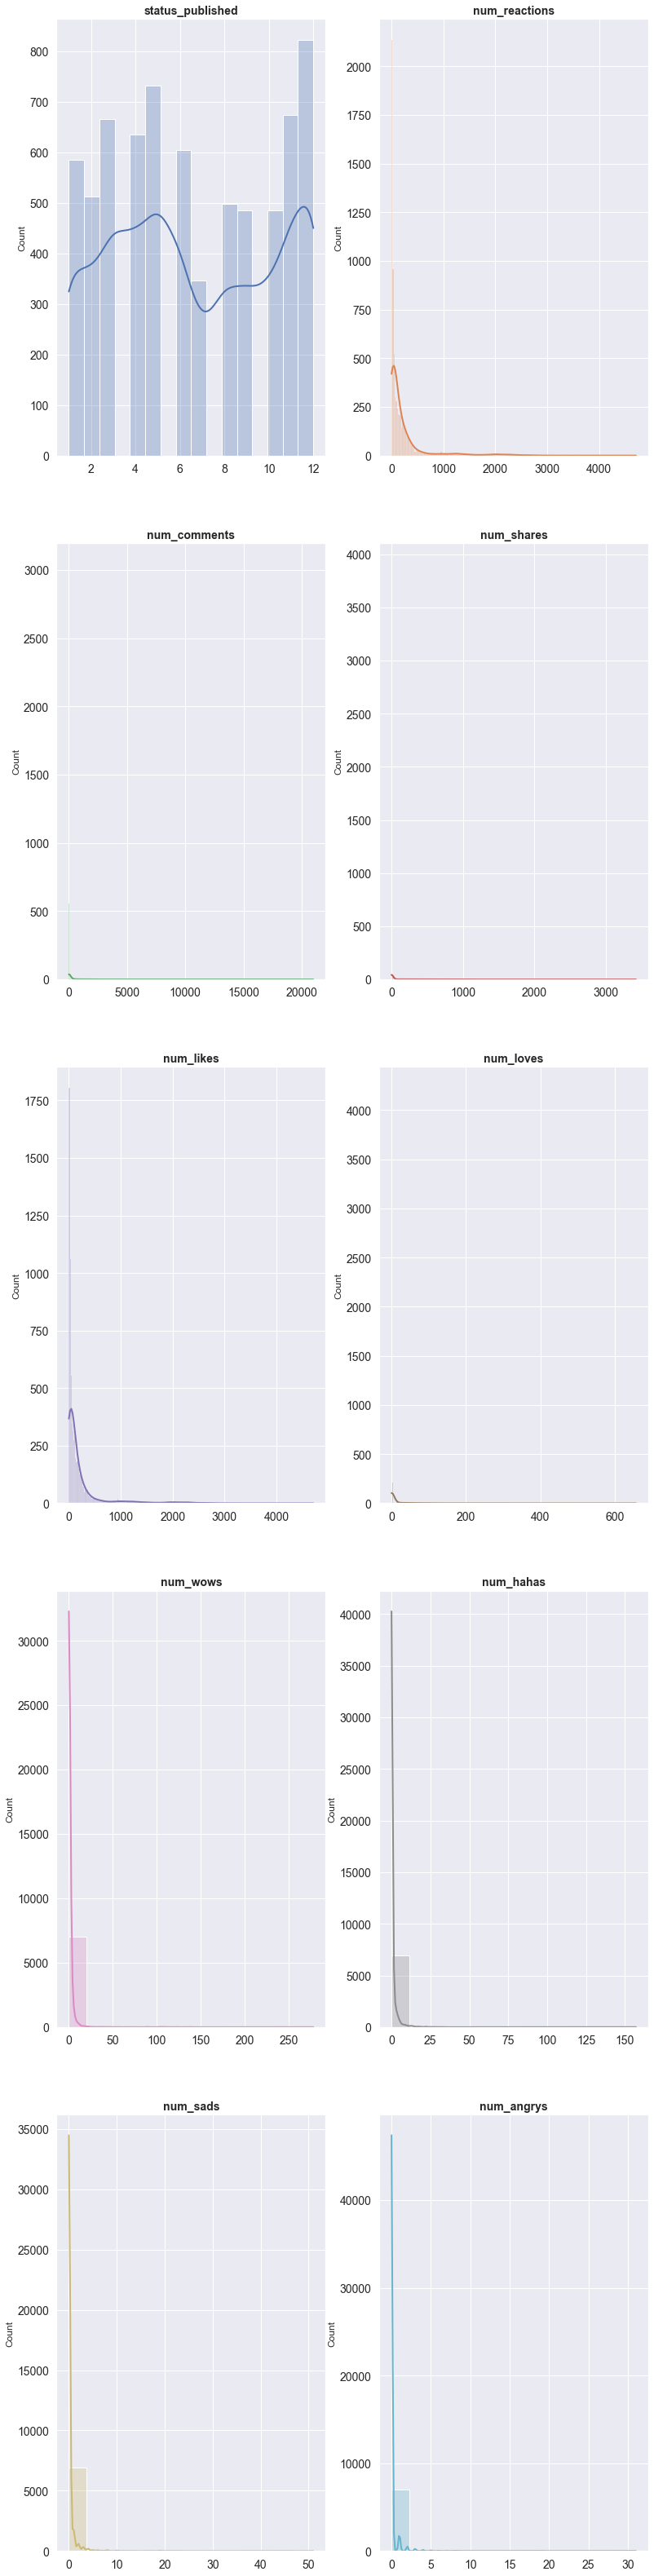

In [3]:
# Distribution graph for each numerical variable

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(13, 15))
axes = axes.flat
columnas_numeric = dfc.select_dtypes(include=['float64', 'int']).columns

for i, column in enumerate(columnas_numeric):
    sns.histplot(
        data    = dfc,
        x       = column,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(column, fontsize = 14, fontweight = "bold")
    axes[i].tick_params(labelsize = 14)
    axes[i].set_xlabel("")

plt.subplots_adjust(top = 3)

- Gràfiques amb la distribució de les variables númeriques del dataset on veiem que la majoria de publicacions no tenen molta interacció

In [4]:
# Correlation between numeric columns
# ==============================================================================
def tidy_corr_matrix(corr_mat):
    
    # Function to convert a pandas correlation matrix to tidy format
    
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = dfc.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
41,num_likes,num_reactions,0.994923,0.994923
14,num_reactions,num_likes,0.994923,0.994923
35,num_shares,num_loves,0.820000,0.820000
53,num_loves,num_shares,0.820000,0.820000
23,num_comments,num_shares,0.640637,0.640637
32,num_shares,num_comments,0.640637,0.640637
52,num_loves,num_comments,0.521223,0.521223
25,num_comments,num_loves,0.521223,0.521223
56,num_loves,num_wows,0.508798,0.508798
65,num_wows,num_loves,0.508798,0.508798


- Correlacions que ens fan reforçar algunes creences entre relacions com el número de likes i de reaccions o el número de vegades compartit i número de _loves_.

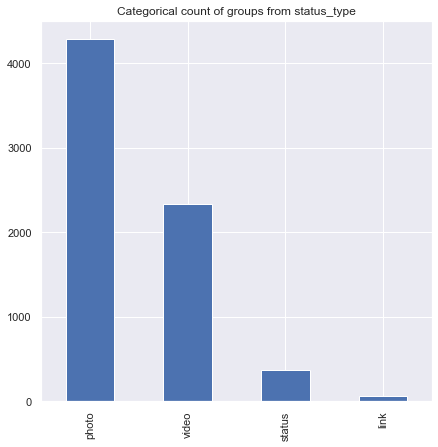

In [5]:
# Qualitative variables (object type)
# ============================================================================
dfc.select_dtypes (include = ['object']).describe()

# Graph for status_type
# ==============================================================================
# Adjust number of subplots based on the number of columns
fig = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
columnas_object = dfc.select_dtypes(include=['object']).columns
columnas_object = columnas_object.drop('status_id')

for i, column in enumerate(columnas_object):
    dfc[column].value_counts().plot.bar()
    plt.title('Categorical count of groups from '+column)

In [6]:
# Adding dummy column
dfcd = pd.concat([dfc, pd.get_dummies(dfc['status_type'], prefix='type')], axis=1)
dfML = dfcd.drop(['status_id','status_type'],axis=1)

scaler = MinMaxScaler()
#scaler = StandardScaler()
X_std0 = scaler.fit_transform(dfML)
X_std=pd.DataFrame(X_std0,columns=dfML.columns)
pd.DataFrame(X_std0).describe().round(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0
mean,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.1,0.3
std,0.3,0.1,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.1,0.5,0.2,0.5
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
75%,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


- És important marcar que les variables amb més _standard deviation_ seràn les que possiblement més informació continguin i més pes tinguin al fer el PCA (Principal Component Analysis)

PCA Explained Variance Ratio: [0.663 0.163 0.114 0.028 0.018 0.007 0.002 0.001 0.001 0.001]


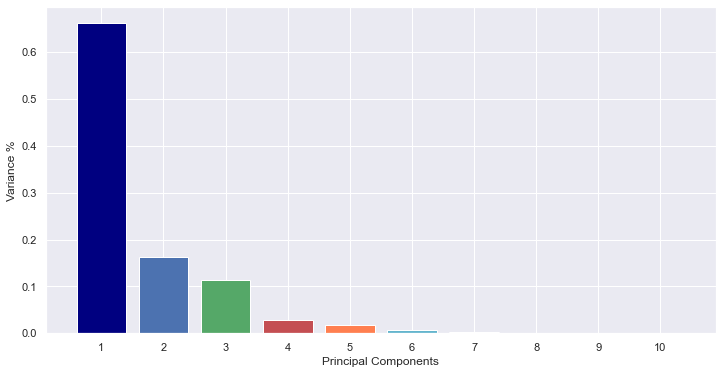

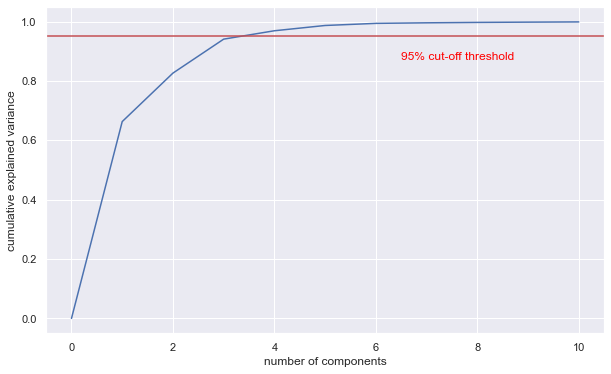

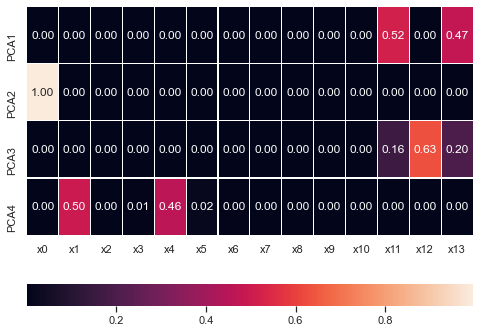

In [7]:
def pcan(N,X_std):
    sns.set(style="darkgrid")
    pca = PCA(n_components = 10)
    principalComponents = pca.fit_transform(X_std)
    print('PCA Explained Variance Ratio:',pca.explained_variance_ratio_.round(3))
    PC = range(1, pca.n_components_+1)
    plt.figure(figsize=(12,6))
    plt.bar(PC, pca.explained_variance_ratio_, color=('navy','b','g','r','coral','c','m','y','k','gray'))
    plt.xlabel('Principal Components')
    plt.ylabel('Variance %')
    plt.xticks(PC);

    #_ = sns.lineplot(x=PC, y=np.cumsum(pca.explained_variance_ratio_), color='black', linestyle='-', linewidth=2, marker='o', markersize=8)
    plt.figure(figsize=(10,6))
    plt.plot(np.append([0],np.cumsum(pca.explained_variance_ratio_)))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(6.5, 0.87, '95% cut-off threshold', color = 'red', fontsize=12);
    col_name = ['x' + str(idx) for idx in range(0, X_std.shape[1])]
    plt.figure(figsize=(8,6))
    _ = sns.heatmap((pca.components_**2)[0:N,:],
                 yticklabels=["PCA"+str(x) for x in range(1,N+1)],
                 xticklabels=list(col_name),
                 annot=True,
                 fmt='.2f',
                 linewidths=0.05,
                 cbar_kws={"orientation": "horizontal"})

pcan(4,X_std)

- Veiem quins són els PCA components amb més variança que poden aportar més informació, reduïnt així la dimensionalitat del dataset

,PC1,PC2,PC3
0,0.907655,0.233909,-0.100575
1,-0.513215,0.235458,-0.050654
2,0.900265,0.227914,-0.102466
3,-0.513459,0.234788,-0.051455
4,-0.512346,0.236626,-0.049771


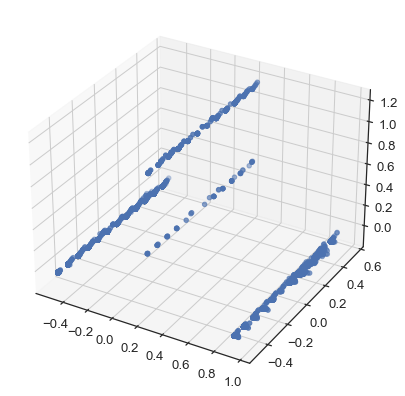

In [8]:
# Perform PCA (Choose n_components to keep)
pca = PCA(n_components=3)
pca_array = pca.fit_transform(X_std)

# Convert back to DataFrame for readability
df_pca = pd.DataFrame(data=pca_array)
df_pca.columns = ['PC' + str(col+1) for col in df_pca.columns.values]

display(df_pca.head())

# Plot Principal Component
_ = sns.set(style='ticks', font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 7))
seaborn_plot = plt.axes (projection='3d')
_ = seaborn_plot.scatter3D(df_pca.iloc[:,0],df_pca.iloc[:,1],df_pca.iloc[:,2])

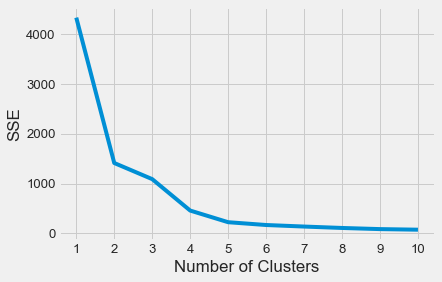

Select 4 clusters as best to execute Kmeans Model


In [9]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)
print(r'Select %s clusters as best to execute Kmeans Model' %kl.elbow)

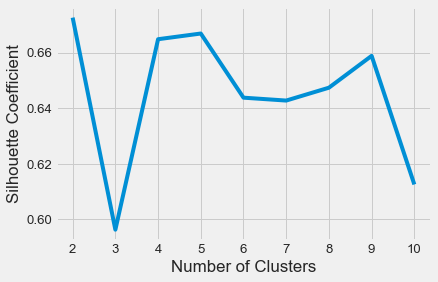

In [10]:
from sklearn.metrics import silhouette_score
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_pca)
    score = silhouette_score(df_pca, kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

- Utilitzem els mètodes de elbow i de silhouette coefficients per veure quins són els millors valors de clusters que podríem determinar

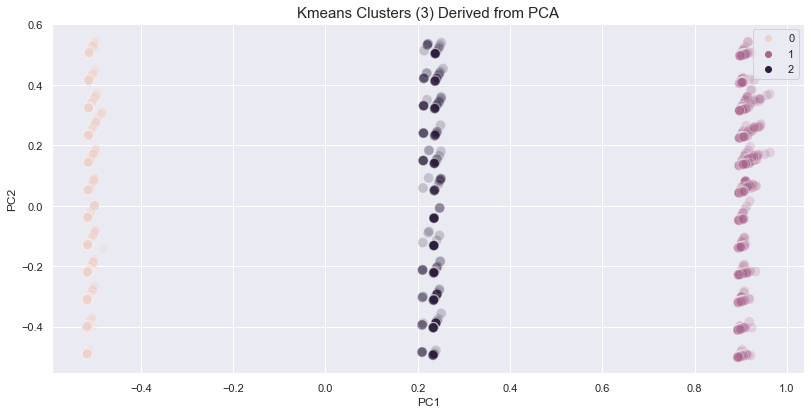

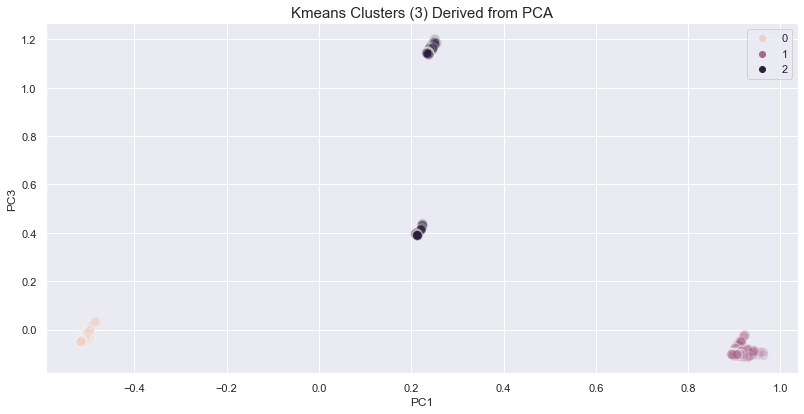

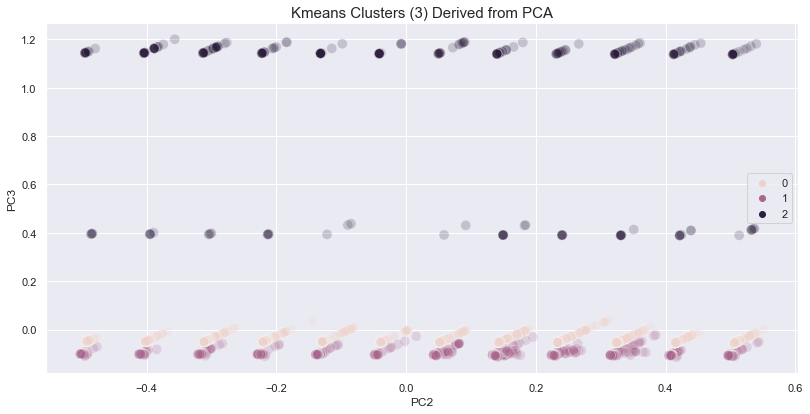

In [11]:
ks=3
sns.set(style="darkgrid")
k_means_pca = KMeans(init = "k-means++", n_clusters = ks, n_init = 12, random_state= 42).fit(df_pca)
labels_pca = k_means_pca.labels_
#display(labels_pca)
clusters_pca = pd.concat([df_pca, pd.DataFrame({'pca_clusters':labels_pca})], axis=1)

plt.figure(figsize=(12,6))

sns.scatterplot(clusters_pca.iloc[:,0], clusters_pca.iloc[:,1],
               hue = labels_pca, s=100,
               alpha=0.2).set_title('Kmeans Clusters (%s) Derived from PCA' %ks,
               fontsize=15)
plt.figure(figsize=(12,6))
sns.scatterplot(clusters_pca.iloc[:,0], clusters_pca.iloc[:,2],
               hue = labels_pca, s=100,
               alpha=0.2).set_title('Kmeans Clusters (%s) Derived from PCA' %ks,
               fontsize=15)
plt.figure(figsize=(12,6))
sns.scatterplot(clusters_pca.iloc[:,1], clusters_pca.iloc[:,2],
               hue = labels_pca, s=100,
               alpha=0.2).set_title('Kmeans Clusters (%s) Derived from PCA' %ks,
               fontsize=15)
plt.legend()
plt.show()

In [12]:
def plotanalys(df):
    sns.set(style="darkgrid")
    fig, (ax1, ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey=True,figsize=(10, 4))
    sns.histplot(data=df, x="type_photo",color="green", ax=ax1 , bins=20)
    sns.histplot(data=df, x="type_video",color="blue", ax=ax2, bins=20)
    sns.histplot(data=df, x="status_published",color="red", ax=ax3, bins=20)

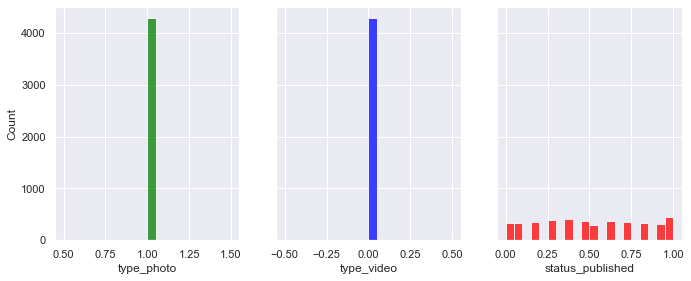

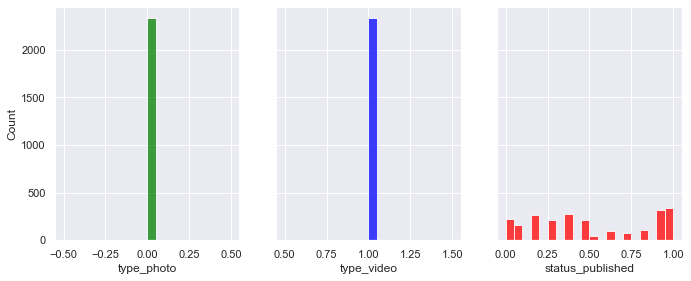

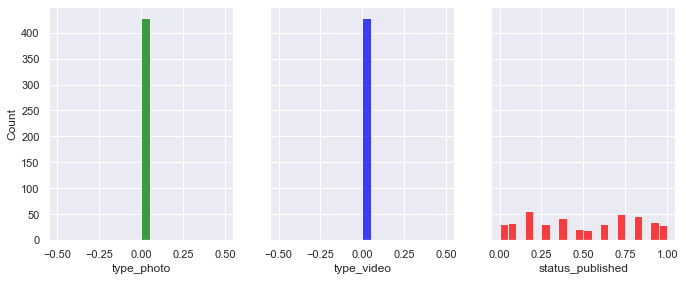

In [13]:
df_pca_kmeans=pd.concat([X_std.reset_index(drop=True), df_pca], axis=1)
df_pca_kmeans['Kmeans PCA'] = labels_pca
for ii in range(0,ks):
    df_cluster_ii = df_pca_kmeans.loc[df_pca_kmeans['Kmeans PCA'] == ii]

    plotanalys(df_cluster_ii)

In [14]:
ks=9
k_means_pca = KMeans(init = "k-means++", n_clusters = ks, n_init = 12, random_state= 42).fit(df_pca)
labels_pca = k_means_pca.labels_
#display(labels_pca)
clusters_pca = pd.concat([df_pca, pd.DataFrame({'Kmeans PCA':labels_pca})], axis=1)
df_pca_kmeans=pd.concat([X_std.reset_index(drop=True), df_pca], axis=1)
df_pca_kmeans['Kmeans PCA'] = labels_pca

## Exercici 2

Classifica els diferents registres utilitzant l'algorisme de clustering jeràrquic.

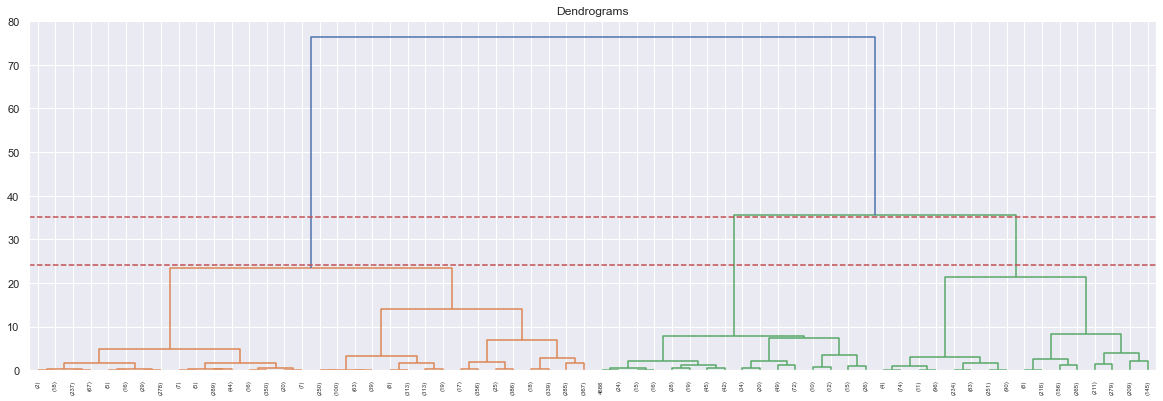

In [15]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(18, 6)) 
plt.title("Dendrograms");
dendrogram = sch.dendrogram(sch.linkage(df_pca, method='ward'),truncate_mode='level', p=5)
plt.axhline(y= 35, color='r', linestyle='--')
plt.axhline(y= 24, color='r', linestyle='--');

- Determinem visualment la regió on hi ha una separació més gran per determinar el nombre òptim de clusters que utilitzar a partir del dendrograma. Representa la divisió en clusters que es porta a terme en l'algorisme de clustering

,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,type_link,type_photo,type_status,type_video,PC1,PC2,PC3,Kmeans PCA,PCA Clusters Hier
0,0.272727,0.112314,0.024393,0.076519,0.091720,0.140030,0.010791,0.006369,0.019608,0.0,0.0,0.0,0.0,1.0,0.907655,0.233909,-0.100575,7,2
1,0.272727,0.031847,0.000000,0.000000,0.031847,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,-0.513215,0.235458,-0.050654,3,1
2,0.272727,0.048195,0.011243,0.016647,0.043312,0.031963,0.003597,0.006369,0.000000,0.0,0.0,0.0,0.0,1.0,0.900265,0.227914,-0.102466,7,2
3,0.272727,0.023567,0.000000,0.000000,0.023567,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,-0.513459,0.234788,-0.051455,3,1
4,0.272727,0.045223,0.000000,0.000000,0.043312,0.013699,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,-0.512346,0.236626,-0.049771,3,1


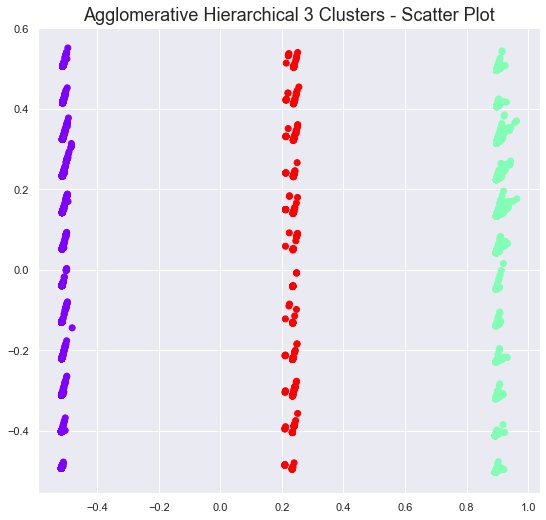

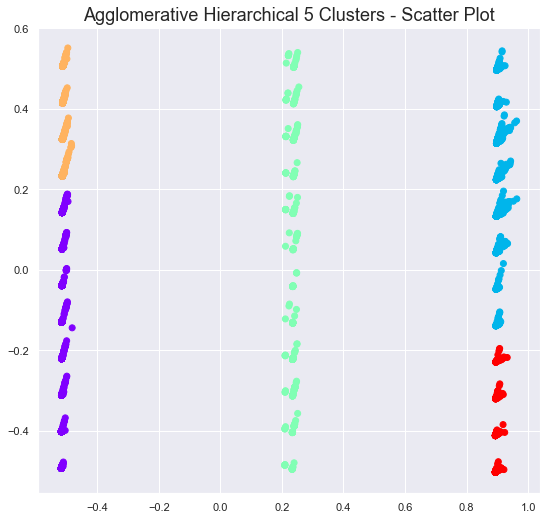

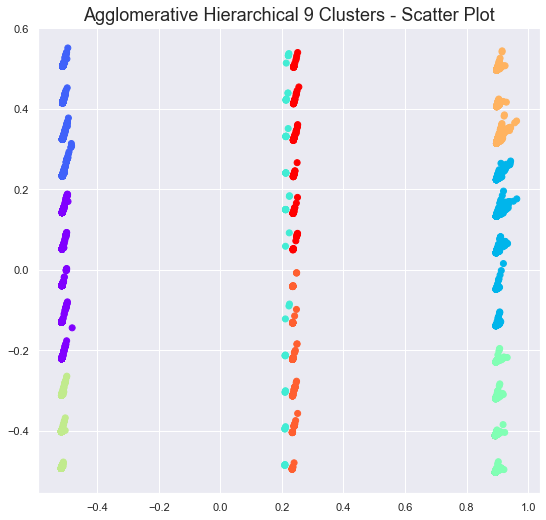

In [16]:
# Create the clusters using Agglomerative hierarchical clustering

agc = AgglomerativeClustering(n_clusters= 3, affinity='euclidean', linkage='ward')
plt.figure(figsize =(8, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c = agc.fit_predict(df_pca), cmap ='rainbow')
plt.title("Agglomerative Hierarchical 3 Clusters - Scatter Plot", fontsize=18);

agc.fit(df_pca)
labels_hier = agc.labels_
labels_hier[:20]

clusters_all_pca3 = pd.concat([df_pca_kmeans, pd.DataFrame({'PCA Clusters Hier':labels_hier})], axis=1)
clusters_all_pca3.head()


# Create the clusters using Agglomerative hierarchical clustering

agc = AgglomerativeClustering(n_clusters= 5, affinity='euclidean', linkage='ward')
plt.figure(figsize =(8, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c = agc.fit_predict(df_pca), cmap ='rainbow')
plt.title("Agglomerative Hierarchical 5 Clusters - Scatter Plot", fontsize=18);

agc.fit(df_pca)
labels_hier = agc.labels_
labels_hier[:20]

clusters_all_pca5 = pd.concat([df_pca_kmeans, pd.DataFrame({'PCA Clusters Hier':labels_hier})], axis=1)
clusters_all_pca5.head()


# Create the clusters using Agglomerative hierarchical clustering

agc = AgglomerativeClustering(n_clusters= 9, affinity='euclidean', linkage='ward')
plt.figure(figsize =(8, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c = agc.fit_predict(df_pca), cmap ='rainbow')
plt.title("Agglomerative Hierarchical 9 Clusters - Scatter Plot", fontsize=18);

agc.fit(df_pca)
labels_hier = agc.labels_
labels_hier[:20]

clusters_all_pca9 = pd.concat([df_pca_kmeans, pd.DataFrame({'PCA Clusters Hier':labels_hier})], axis=1)
clusters_all_pca9.head()

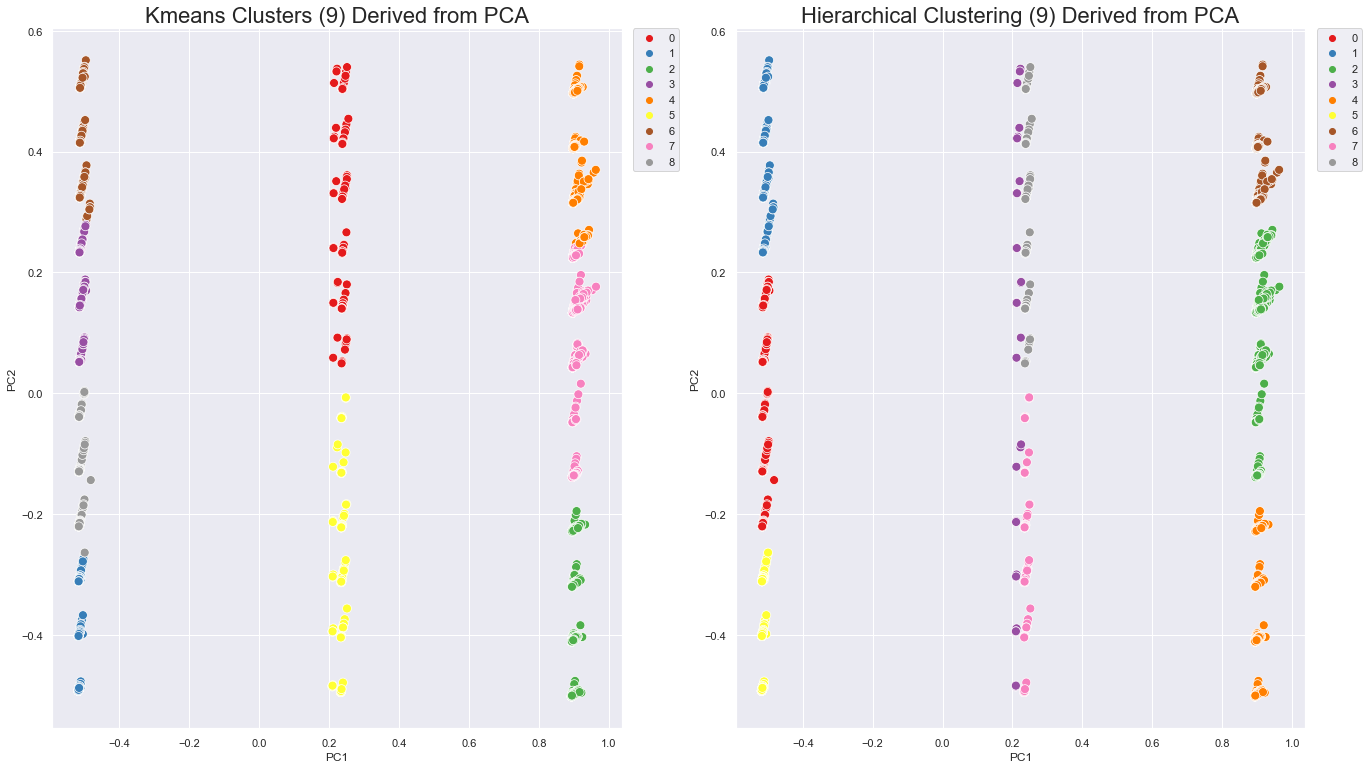

In [17]:
# Scatter plot using the first 2 Principal Components to observe the Cluster Distribution

plt.figure(figsize=(20,12))

plt.subplot(1,2,1)
sns.scatterplot(x= 'PC1', y='PC2',
                data= clusters_all_pca9,
                hue = 'Kmeans PCA', palette='Set1', s= 80).set_title('Kmeans Clusters (9) Derived from PCA',
                fontsize= 22)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)



plt.subplot(1,2,2)
sns.scatterplot(x= 'PC1', y='PC2',
                data= clusters_all_pca9, s=80, 
                hue= 'PCA Clusters Hier',palette='Set1').set_title('Hierarchical Clustering (9) Derived from PCA',
                fontsize=22);
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

- Exemple comparatiu de Clustering utilitzant K-means i Hierarchical Clustering amb 9 clusters

## Exercici 3

Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

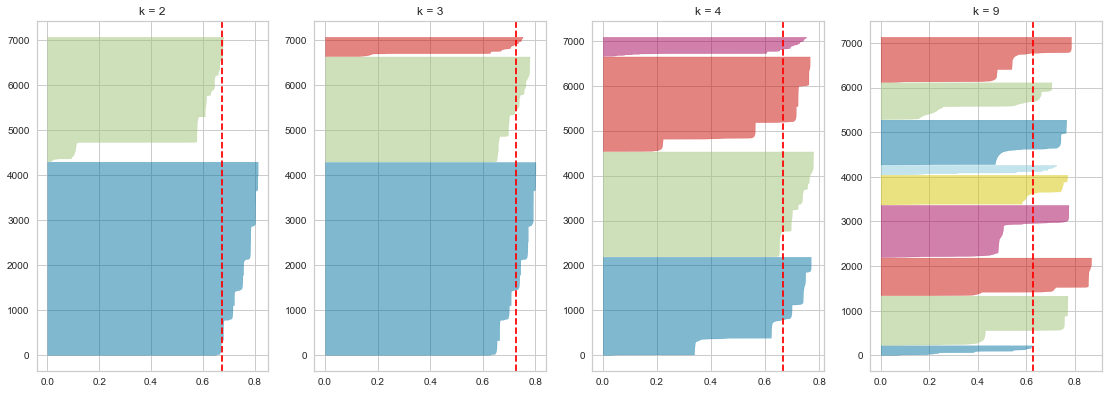

In [18]:
# SilhouetteVisualizer
# ==============================================================================
from yellowbrick.cluster import SilhouetteVisualizer

fig,(ax1,ax2,ax3,ax4)=plt.subplots(figsize=(17,6),nrows=1,ncols=4)

#ax1
visualizer = SilhouetteVisualizer(KMeans(init = "k-means++",n_clusters=2, random_state=42), colors='yellowbrick',ax=ax1)
visualizer.fit(df_pca)       # Fit the data to the visualizer
ax1.set_title('k = 2')               # Title
sil1=silhouette_score(df_pca, KMeans(init = "k-means++",n_clusters=2, random_state=42).fit(df_pca).labels_)

#ax2
visualizer2 = SilhouetteVisualizer(KMeans(init = "k-means++",n_clusters=3, random_state=42), colors='yellowbrick',ax=ax2)
visualizer2.fit(df_pca)      # Fit the data to the visualizer
ax2.set_title('k = 3')               # Title
sil2=silhouette_score(df_pca, KMeans(init = "k-means++",n_clusters=3, random_state=42).fit(df_pca).labels_)

#ax3
visualizer3 = SilhouetteVisualizer(KMeans(init = "k-means++",n_clusters=4, random_state=42), colors='yellowbrick',ax=ax3)
visualizer3.fit(df_pca)       # Fit the data to the visualizer
ax3.set_title('k = 4');               # Title
sil3=silhouette_score(df_pca, KMeans(init = "k-means++",n_clusters=4, random_state=42).fit(df_pca).labels_)

#ax4
visualizer4 = SilhouetteVisualizer(KMeans(init = "k-means++",n_clusters=9, random_state=42), colors='yellowbrick',ax=ax4)
visualizer4.fit(df_pca)       # Fit the data to the visualizer
ax4.set_title('k = 9');              # Title   
sil4=silhouette_score(df_pca, KMeans(init = "k-means++",n_clusters=9, random_state=42).fit(df_pca).labels_)

In [19]:
silhouette = pd.DataFrame({'Measure': ['2 Clusters' ,'3 Clusters', '4 Clusters', '9 Clusters'],
                            'Scores': [sil1,sil2,sil3,sil4]
                            })
silhouette

,Measure,Scores
0,2 Clusters,0.672657
1,3 Clusters,0.727789
2,4 Clusters,0.664881
3,9 Clusters,0.626738


- El paràmetre silhouette ajuda a determinar com de similars són punts de un cluster amb els altres diferents clusters. Quanta més valoració del paràmetre silhouette, millor agrupació o més cohesió hi ha entre punts del mateix cluster.

# Extra section

- Anem a fer aquest mateix anàlisis aplicant l'estandaritzat estàndard per veure com canvien els clusters

In [20]:
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_std0 = scaler.fit_transform(dfML)
X_std=pd.DataFrame(X_std0,columns=dfML.columns)
pd.DataFrame(X_std0).describe().round(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0,7050.0
mean,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.6,-0.5,-0.3,-0.3,-0.5,-0.3,-0.1,-0.2,-0.2,-0.2,-0.1,-1.2,-0.2,-0.7
25%,-1.0,-0.5,-0.3,-0.3,-0.4,-0.3,-0.1,-0.2,-0.2,-0.2,-0.1,-1.2,-0.2,-0.7
50%,-0.2,-0.4,-0.2,-0.3,-0.3,-0.3,-0.1,-0.2,-0.2,-0.2,-0.1,0.8,-0.2,-0.7
75%,1.0,-0.0,-0.2,-0.3,-0.1,-0.2,-0.1,-0.2,-0.2,-0.2,-0.1,0.8,-0.2,1.4
max,1.5,9.7,23.3,25.7,10.0,16.1,31.7,39.5,31.8,42.5,10.5,0.8,4.3,1.4


PCA Explained Variance Ratio: [0.276 0.136 0.106 0.077 0.072 0.07  0.066 0.059 0.053 0.049]


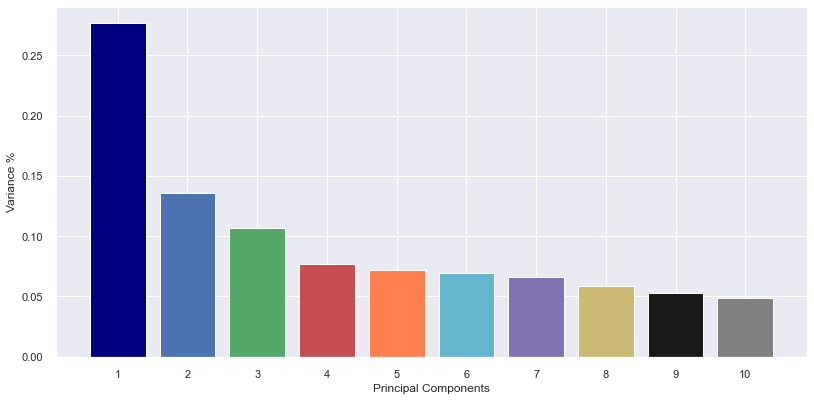

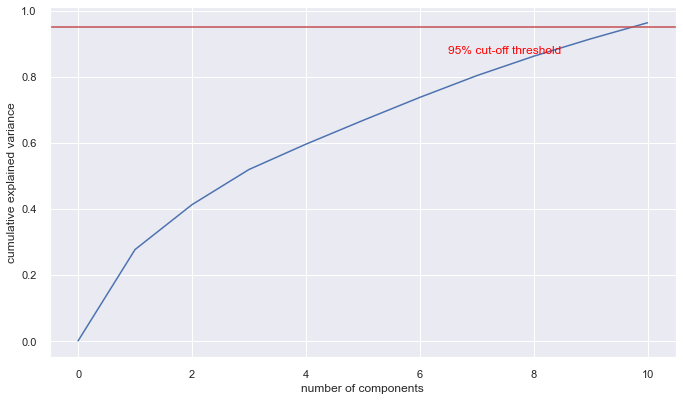

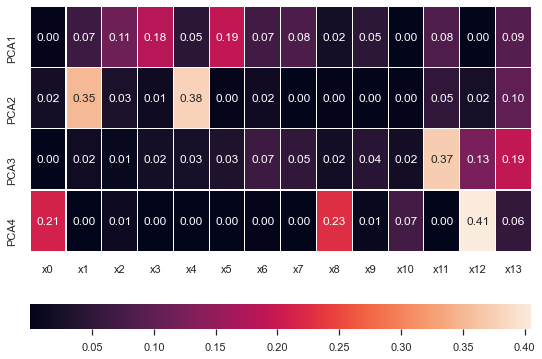

In [21]:
pcan(4,X_std)

,PC1,PC2,PC3
0,2.900869,-0.366195,-0.713281
1,-0.991235,0.381651,0.677323
2,0.918009,-0.706606,-1.274291
3,-1.031437,0.278177,0.702570
4,-0.831252,0.521203,0.680444


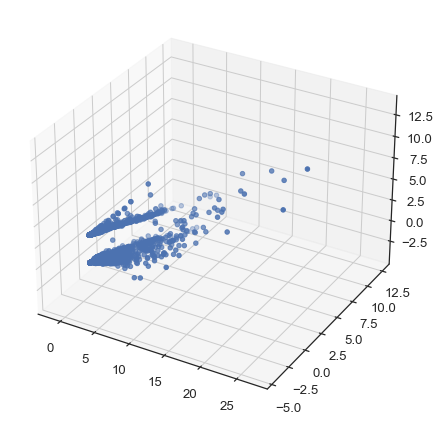

In [22]:
# Perform PCA (Choose n_components to keep)
pca = PCA(n_components=3)
pca_array = pca.fit_transform(X_std)

# Convert back to DataFrame for readability
df_pca = pd.DataFrame(data=pca_array)
df_pca.columns = ['PC' + str(col+1) for col in df_pca.columns.values]

display(df_pca.head())

# Plot Principal Component
_ = sns.set(style='ticks', font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 7))
seaborn_plot = plt.axes (projection='3d')
_ = seaborn_plot.scatter3D(df_pca.iloc[:,0],df_pca.iloc[:,1],df_pca.iloc[:,2])

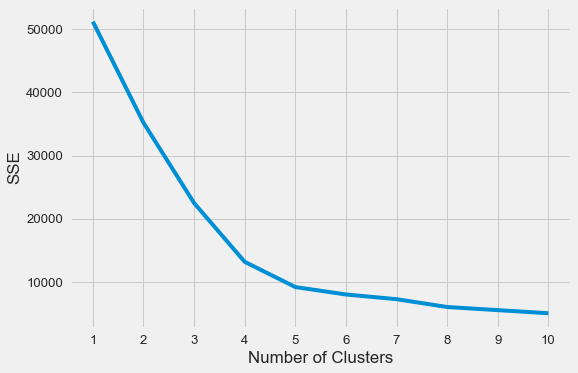

Select 4 clusters as best to execute Kmeans Model


In [23]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)
print(r'Select %s clusters as best to execute Kmeans Model' %kl.elbow)

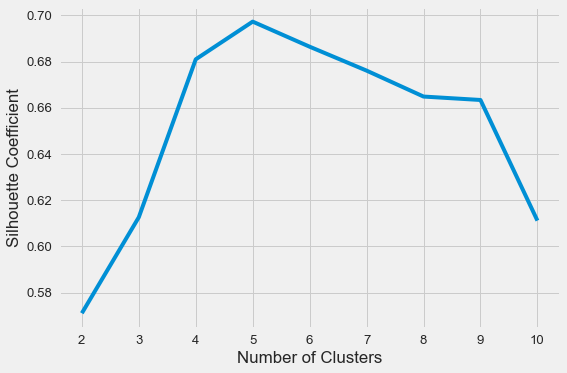

In [24]:
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_pca)
    score = silhouette_score(df_pca, kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

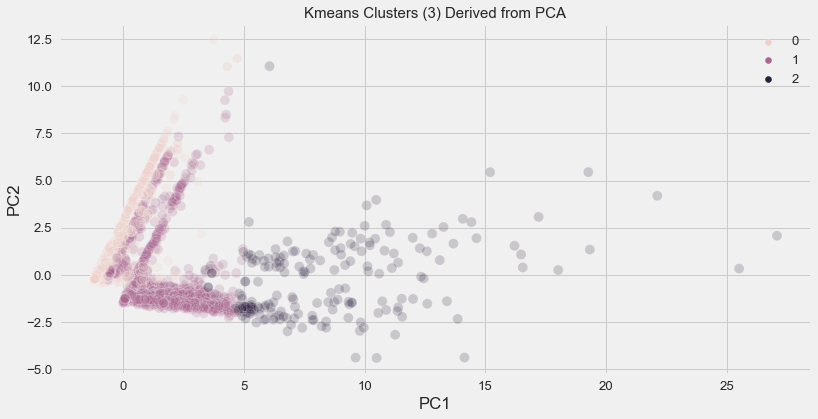

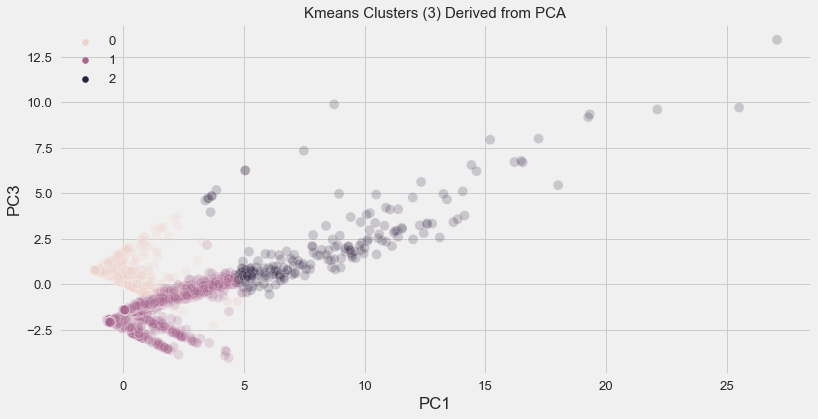

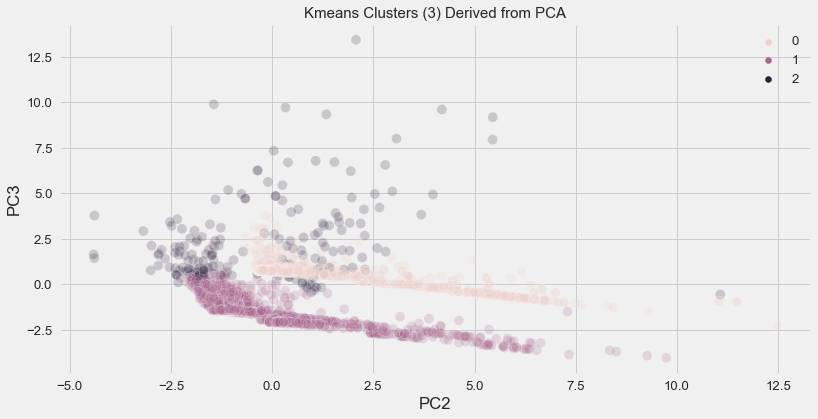

In [25]:
ks=3
k_means_pca = KMeans(init = "k-means++", n_clusters = ks, n_init = 12, random_state= 42).fit(df_pca)
labels_pca = k_means_pca.labels_
#display(labels_pca)
clusters_pca = pd.concat([df_pca, pd.DataFrame({'pca_clusters':labels_pca})], axis=1)

plt.figure(figsize=(12,6))

sns.scatterplot(clusters_pca.iloc[:,0], clusters_pca.iloc[:,1],
               hue = labels_pca, s=100,
               alpha=0.2).set_title('Kmeans Clusters (%s) Derived from PCA' %ks,
               fontsize=15)
plt.figure(figsize=(12,6))
sns.scatterplot(clusters_pca.iloc[:,0], clusters_pca.iloc[:,2],
               hue = labels_pca, s=100,
               alpha=0.2).set_title('Kmeans Clusters (%s) Derived from PCA' %ks,
               fontsize=15)
plt.figure(figsize=(12,6))
sns.scatterplot(clusters_pca.iloc[:,1], clusters_pca.iloc[:,2],
               hue = labels_pca, s=100,
               alpha=0.2).set_title('Kmeans Clusters (%s) Derived from PCA' %ks,
               fontsize=15)
plt.legend()
plt.show()

In [26]:
ks=9
k_means_pca = KMeans(init = "k-means++", n_clusters = ks, n_init = 12, random_state= 42).fit(df_pca)
labels_pca = k_means_pca.labels_
#display(labels_pca)
clusters_pca = pd.concat([df_pca, pd.DataFrame({'Kmeans PCA':labels_pca})], axis=1)
df_pca_kmeans=pd.concat([X_std.reset_index(drop=True), df_pca], axis=1)
df_pca_kmeans['Kmeans PCA'] = labels_pca

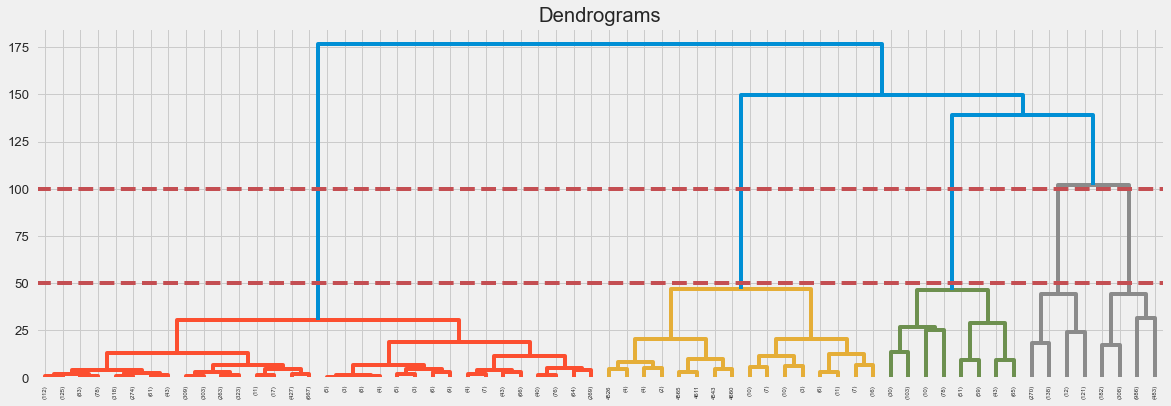

In [27]:
plt.figure(figsize=(18, 6)) 
plt.title("Dendrograms");
dendrogram = sch.dendrogram(sch.linkage(df_pca, method='ward'),truncate_mode='level', p=5)
plt.axhline(y= 100, color='r', linestyle='--')
plt.axhline(y= 50, color='r', linestyle='--');

,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,type_link,type_photo,type_status,type_video,PC1,PC2,PC3,Kmeans PCA,PCA Clusters Hier
0,-0.718661,0.646104,0.323350,1.686879,0.482727,1.983266,0.196196,0.076713,0.473570,-0.155748,-0.094957,-1.245993,-0.233666,1.421466,2.900869,-0.366195,-0.713281,2,8
1,-0.718661,-0.173192,-0.252206,-0.304144,-0.144720,-0.318454,-0.147879,-0.176010,-0.152587,-0.155748,-0.094957,0.802573,-0.233666,-0.703499,-0.991235,0.381651,0.677323,0,1
2,-0.718661,-0.006738,0.013089,0.129017,-0.024571,0.206938,-0.033187,0.076713,-0.152587,-0.155748,-0.094957,-1.245993,-0.233666,1.421466,0.918009,-0.706606,-1.274291,4,0
3,-0.718661,-0.257499,-0.252206,-0.304144,-0.231495,-0.318454,-0.147879,-0.176010,-0.152587,-0.155748,-0.094957,0.802573,-0.233666,-0.703499,-1.031437,0.278177,0.702570,0,1
4,-0.718661,-0.037003,-0.252206,-0.304144,-0.024571,-0.093286,-0.147879,-0.176010,-0.152587,-0.155748,-0.094957,0.802573,-0.233666,-0.703499,-0.831252,0.521203,0.680444,0,1


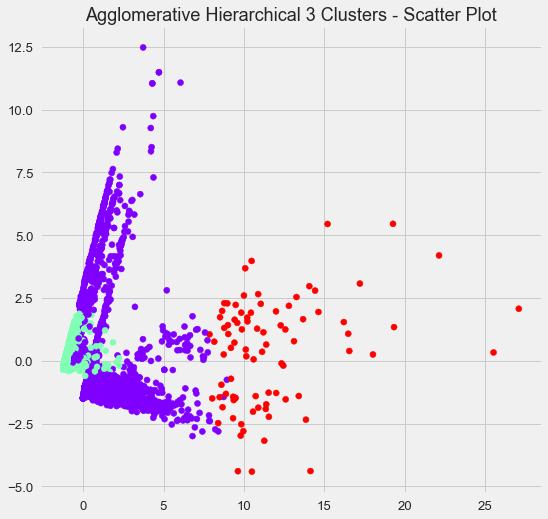

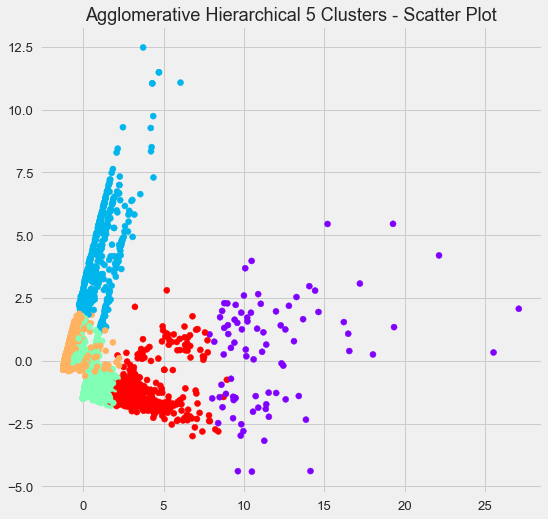

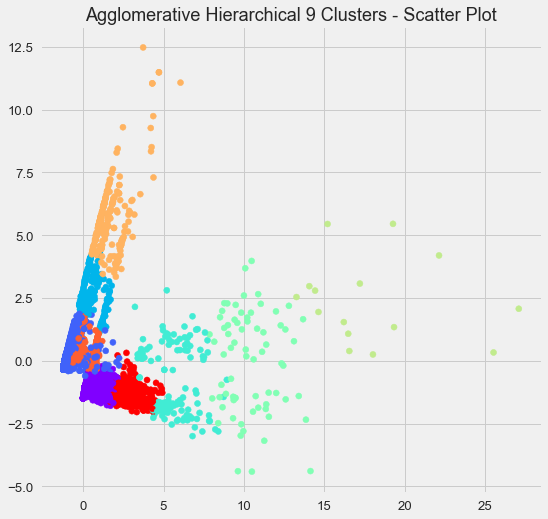

In [28]:
# Create the clusters using Agglomerative hierarchical clustering

agc = AgglomerativeClustering(n_clusters= 3, affinity='euclidean', linkage='ward')
plt.figure(figsize =(8, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c = agc.fit_predict(df_pca), cmap ='rainbow')
plt.title("Agglomerative Hierarchical 3 Clusters - Scatter Plot", fontsize=18);

agc.fit(df_pca)
labels_hier = agc.labels_
labels_hier[:20]

clusters_all_pca3 = pd.concat([df_pca_kmeans, pd.DataFrame({'PCA Clusters Hier':labels_hier})], axis=1)
clusters_all_pca3.head()


# Create the clusters using Agglomerative hierarchical clustering

agc = AgglomerativeClustering(n_clusters= 5, affinity='euclidean', linkage='ward')
plt.figure(figsize =(8, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c = agc.fit_predict(df_pca), cmap ='rainbow')
plt.title("Agglomerative Hierarchical 5 Clusters - Scatter Plot", fontsize=18);

agc.fit(df_pca)
labels_hier = agc.labels_
labels_hier[:20]

clusters_all_pca5 = pd.concat([df_pca_kmeans, pd.DataFrame({'PCA Clusters Hier':labels_hier})], axis=1)
clusters_all_pca5.head()


# Create the clusters using Agglomerative hierarchical clustering

agc = AgglomerativeClustering(n_clusters= 9, affinity='euclidean', linkage='ward')
plt.figure(figsize =(8, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c = agc.fit_predict(df_pca), cmap ='rainbow')
plt.title("Agglomerative Hierarchical 9 Clusters - Scatter Plot", fontsize=18);

agc.fit(df_pca)
labels_hier = agc.labels_
labels_hier[:20]

clusters_all_pca9 = pd.concat([df_pca_kmeans, pd.DataFrame({'PCA Clusters Hier':labels_hier})], axis=1)
clusters_all_pca9.head()

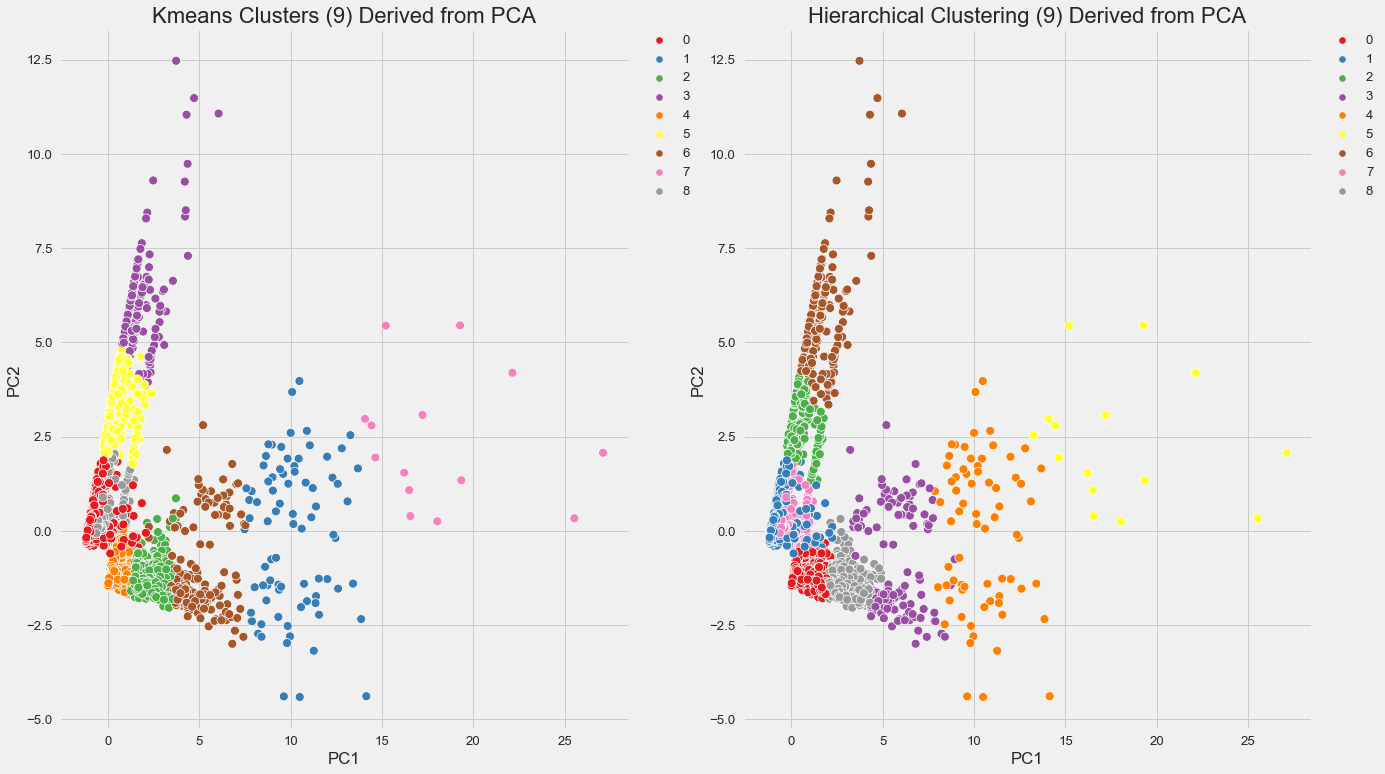

In [29]:
# Scatter plot using the first 2 Principal Components to observe the Cluster Distribution

plt.figure(figsize=(20,12))

plt.subplot(1,2,1)
sns.scatterplot(x= 'PC1', y='PC2',
                data= clusters_all_pca9,
                hue = 'Kmeans PCA', palette='Set1', s= 80).set_title('Kmeans Clusters (9) Derived from PCA',
                fontsize= 22)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)



plt.subplot(1,2,2)
sns.scatterplot(x= 'PC1', y='PC2',
                data= clusters_all_pca9, s=80, 
                hue= 'PCA Clusters Hier',palette='Set1').set_title('Hierarchical Clustering (9) Derived from PCA',
                fontsize=22);
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

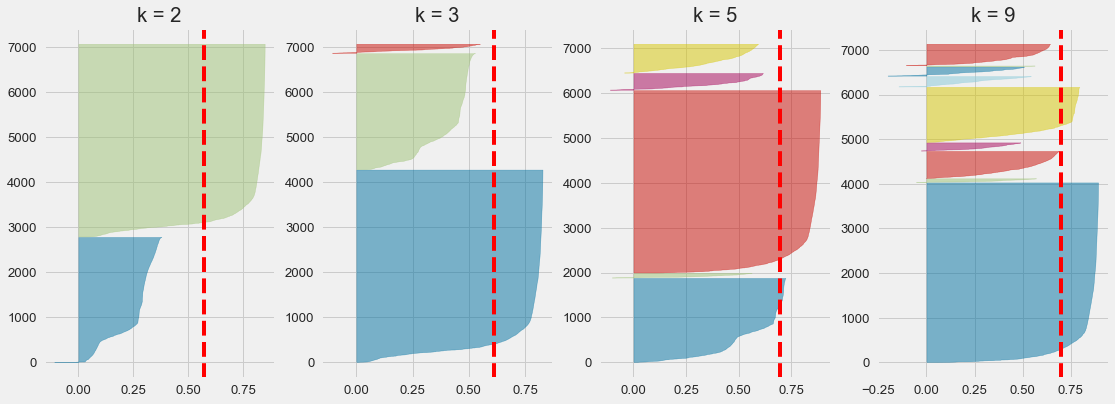

In [30]:
# SilhouetteVisualizer
# ==============================================================================

fig,(ax1,ax2,ax3,ax4)=plt.subplots(figsize=(17,6),nrows=1,ncols=4)

#ax1
visualizer = SilhouetteVisualizer(KMeans(init = "k-means++",n_clusters=2, random_state=42), colors='yellowbrick',ax=ax1)
visualizer.fit(df_pca)       # Fit the data to the visualizer
ax1.set_title('k = 2')               # Title
sil1=silhouette_score(df_pca, KMeans(init = "k-means++",n_clusters=2, random_state=42).fit(df_pca).labels_)

#ax2
visualizer2 = SilhouetteVisualizer(KMeans(init = "k-means++",n_clusters=3, random_state=42), colors='yellowbrick',ax=ax2)
visualizer2.fit(df_pca)      # Fit the data to the visualizer
ax2.set_title('k = 3')               # Title
sil2=silhouette_score(df_pca, KMeans(init = "k-means++",n_clusters=3, random_state=42).fit(df_pca).labels_)

#ax3
visualizer3 = SilhouetteVisualizer(KMeans(init = "k-means++",n_clusters=5, random_state=42), colors='yellowbrick',ax=ax3)
visualizer3.fit(df_pca)       # Fit the data to the visualizer
ax3.set_title('k = 5');               # Title
sil3=silhouette_score(df_pca, KMeans(init = "k-means++",n_clusters=5, random_state=42).fit(df_pca).labels_)

#ax4
visualizer4 = SilhouetteVisualizer(KMeans(init = "k-means++",n_clusters=9, random_state=42), colors='yellowbrick',ax=ax4)
visualizer4.fit(df_pca)       # Fit the data to the visualizer
ax4.set_title('k = 9');              # Title   
sil4=silhouette_score(df_pca, KMeans(init = "k-means++",n_clusters=9, random_state=42).fit(df_pca).labels_)

In [32]:
silhouette = pd.DataFrame({'Measure': ['2 Clusters' ,'3 Clusters', '5 Clusters', '9 Clusters'],
                            'Scores': [sil1,sil2,sil3,sil4]
                            })
silhouette

,Measure,Scores
0,2 Clusters,0.571075
1,3 Clusters,0.612628
2,5 Clusters,0.697317
3,9 Clusters,0.697545


- Podem veure resultats en les agrupacions totalment diferents ja que les variances s'han dividit més equitativament entre les diferents variables/features. Això ha generat que els components del PCA que s'han creat siguin diferents als anteriors proporcionant una reducció de dimensionalitat diferent i obtenint per així dir-ho, diferents punts projectats entre el mètode amb estandarització estandard i MinMax.